In [ ]:
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.debugging.set_log_device_placement(False)

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from training import import_images, Model
from app import predict_image

Found 6000 files belonging to 5 classes.
Found 2000 files belonging to 5 classes.
Number of validation batches: 51
Number of test batches: 12
> c:\users\hp\desktop\learning\image_recognition\training.py(94)train()
-> self.history = model.fit(self.train_dataset, epochs=initial_epochs, validation_data=self.validation_dataset)


In [ ]:
path = 'C:\\Users\\HP\\Desktop\\learning\\image_recognition'

train_dataset, validation_dataset, val_batches, test_dataset, IMG_SIZE = import_images(path)

In [ ]:
with tf.device("/gpu:0"):
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### Data augmentation


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, 0))

])

In [ ]:
for image, _ in train_dataset.take(1):

    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
train_dataset

### Base Model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
tf.reduce_mean(feature_batch,[1,2] ).shape

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")
prediction_batch =  prediction_layer(feature_batch_average)

In [ ]:
with tf.device("/gpu:0"):
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.27
initial accuracy: 0.10


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
188/188 [==============================] - 13s 50ms/step - loss: 1.6766 - accuracy: 0.3347 - val_loss: 1.0565 - val_accuracy: 0.6015
Epoch 2/10
188/188 [==============================] - 10s 51ms/step - loss: 0.9053 - accuracy: 0.6695 - val_loss: 0.6568 - val_accuracy: 0.8038
Epoch 3/10
188/188 [==============================] - 10s 51ms/step - loss: 0.6309 - accuracy: 0.7892 - val_loss: 0.4855 - val_accuracy: 0.8682
Epoch 4/10
188/188 [==============================] - 10s 50ms/step - loss: 0.5007 - accuracy: 0.8367 - val_loss: 0.4086 - val_accuracy: 0.8880
Epoch 5/10
188/188 [==============================] - 10s 52ms/step - loss: 0.4430 - accuracy: 0.8512 - val_loss: 0.3378 - val_accuracy: 0.9140
Epoch 6/10
188/188 [==============================] - 10s 51ms/step - loss: 0.3884 - accuracy: 0.8753 - val_loss: 0.3110 - val_accuracy: 0.9220
Epoch 7/10
188/188 [==============================] - 9s 50ms/step - loss: 0.3695 - accuracy: 0.8797 - val_loss: 0.2791 - val_accuracy: 

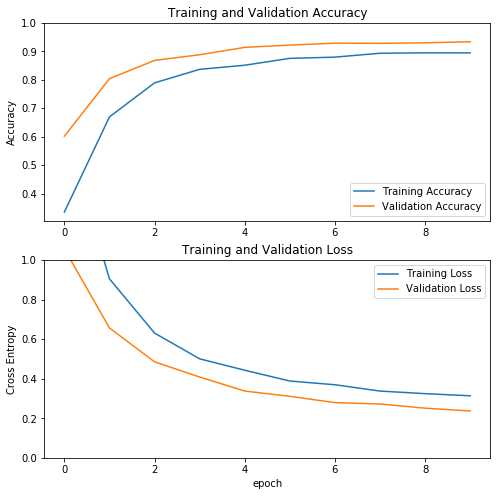

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False



Number of layers in the base model:  154


In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
len(model.trainable_variables)

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


107

In [24]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
188/188 [==============================] - 28s 106ms/step - loss: 0.2605 - accuracy: 0.9142 - val_loss: 0.1704 - val_accuracy: 0.9517
Epoch 11/20
188/188 [==============================] - 19s 99ms/step - loss: 0.2058 - accuracy: 0.9333 - val_loss: 0.1304 - val_accuracy: 0.9629
Epoch 12/20
188/188 [==============================] - 19s 100ms/step - loss: 0.1762 - accuracy: 0.9407 - val_loss: 0.1062 - val_accuracy: 0.9666
Epoch 13/20
188/188 [==============================] - 19s 100ms/step - loss: 0.1539 - accuracy: 0.9497 - val_loss: 0.1068 - val_accuracy: 0.9684
Epoch 14/20
188/188 [==============================] - 19s 100ms/step - loss: 0.1309 - accuracy: 0.9530 - val_loss: 0.1066 - val_accuracy: 0.9623
Epoch 15/20
188/188 [==============================] - 19s 102ms/step - loss: 0.1180 - accuracy: 0.9578 - val_loss: 0.1032 - val_accuracy: 0.9672
Epoch 16/20
188/188 [==============================] - 19s 99ms/step - loss: 0.1110 - accuracy: 0.9587 - val_loss: 0.0948 - v

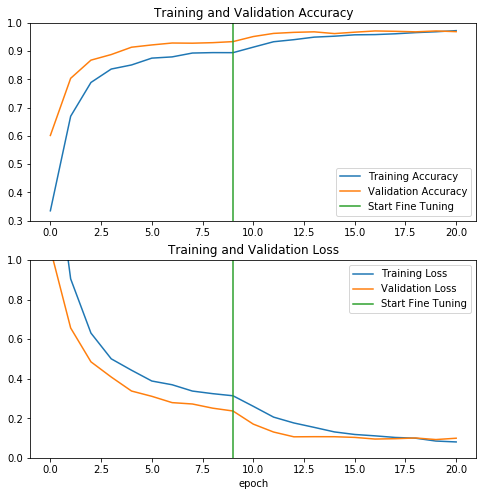

In [28]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 1s 41ms/step - loss: 0.1028 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [1, 3, 3, 2, 2, 1, 1, 1, 3, 3, 0, 1, 0, 2, 2, 0, 1, 1, 1, 4, 3, 0, 4, 0, 1, 1, 0, 1, 3, 4, 2, 2]
Labels:
 [1 3 3 2 2 1 1 1 3 3 0 1 0 2 2 0 1 1 1 4 3 0 4 0 1 1 0 1 3 0 2 2]


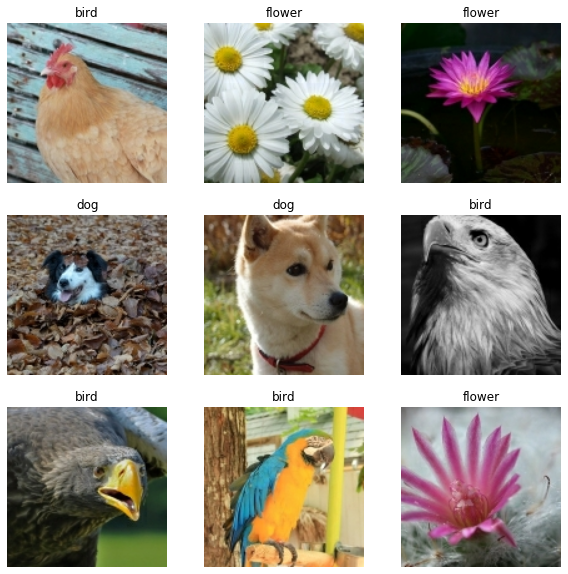

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.softmax(predictions)
predictions = [np.argmax(pred) for pred in predictions]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [33]:
# Saving the model (save model weight)
model.save("trained_model")

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: trained_model\assets


In [4]:
model2 = tf.keras.models.load_model("trained_model")

In [37]:
np.argmax(model2.predict(container * 256)[0])

2

In [14]:
class_names = train_dataset.class_names
class_names

['berry', 'bird', 'dog', 'flower', 'other']

In [15]:
image_batch.shape

NameError: name 'image_batch' is not defined

In [16]:
def predict_image(image_batch, model, class_names):
    predictions = model.predict(image_batch)
    predictions = [np.argmax(pred) for pred in predictions]
    return [class_names[pred] for pred in predictions] 

In [122]:
predict_image(image_batch, model, class_names)

['bird',
 'flower',
 'flower',
 'dog',
 'dog',
 'bird',
 'bird',
 'bird',
 'flower',
 'flower',
 'berry',
 'bird',
 'berry',
 'dog',
 'dog',
 'berry',
 'bird',
 'bird',
 'bird',
 'other',
 'flower',
 'berry',
 'other',
 'berry',
 'bird',
 'bird',
 'berry',
 'bird',
 'flower',
 'other',
 'dog',
 'dog']

In [17]:
from PIL import Image
container = []
for file_name in os.listdir("test"):
    container.append(np.array(Image.open(os.path.join("test", file_name))))
    
[c.shape for c in container]

container = [resize(img, [160,160] ) for img in container]
#5 160 160 3

In [22]:
container = np.array(container)
predict_image(container*256, model2, class_names)


['dog', 'dog', 'flower', 'flower', 'bird', 'bird']

In [125]:
os.listdir("test")

['doggo_1.jpg',
 'doggo_2.jpg',
 'flower_1.jpg',
 'flower_2.jpg',
 'kiwi.jpg',
 'kiwi_2.jpg']

In [126]:
np.stack(container).shape

(6, 160, 160, 3)

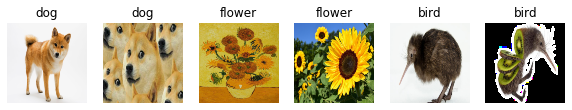

In [127]:
plt.figure(figsize=(10, 10))
for i in range(len(container)):
    ax = plt.subplot(1, 6, i+ 1)
    plt.imshow((container[i]*256).astype("uint8"))
    plt.title(predict_image(container*256, model, class_names)[i])
    plt.axis("off")

In [1]:
class_names

NameError: name 'class_names' is not defined

In [102]:
container[0]c.astype("uint8")

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [77]:
image_batch.shape

(32, 160, 160, 3)

In [56]:
os.path.join("test", "flower_1.jpg")

'test\\flower_1.jpg'

In [83]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [10]:
from skimage.transform import resize